In [1]:
import pandas as pd
import numpy as np
import ast  # For safe evaluation of Python-like strings
from transformers import BertTokenizer
import pickle as pkl
from dataset import RedlistDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import AdamW
from model import RedlistPredictor
from tqdm import tqdm
from transformers import get_scheduler
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [2]:
with open("data/data_splits.pkl", "rb") as f:
    data = pkl.load(f)
    unknown_values = pkl.load(f)

df_train = data["train"]
df_test = data["test"]
df_deficient = data["deficient"]

In [4]:
for df_name, df in [("df_train", df_train), ("df_test", df_test), ("df_deficient", df_deficient)]:
    avg_nulls_per_row = df.isnull().sum(axis=1).mean()
    print(f"Average number of null/None values per row in {df_name}: {avg_nulls_per_row:.2f}")

Average number of null/None values per row in df_train: 0.00
Average number of null/None values per row in df_test: 0.00
Average number of null/None values per row in df_deficient: 0.00


In [5]:
print(df_train.columns)
print(df_train['structured_vector'].iloc[0].shape)  # Should be a NumPy array
print(df_train['text_input'].iloc[0][:1000])  # First 100 characters of a sample text input

Index(['assessmentId', 'scientificName', 'internalTaxonId', 'redlistCategory',
       'rationale', 'habitat', 'threats', 'population', 'range', 'useTrade',
       'conservationActions', 'populationTrend', 'possiblyExtinct',
       'possiblyExtinctInTheWild', 'realm_vector', 'systems_vector',
       'className', 'orderName', 'familyName', 'genusName', 'className_idx',
       'orderName_idx', 'familyName_idx', 'genusName_idx', 'structured_vector',
       'text_input'],
      dtype='object')
(15,)
this species is listed as [REDACTED] in view of its wide distribution, presumed large population, and because it is unlikely to be declining at nearly the rate required to qualify for listing in a threatened category. [SEP] this species occurs in tropical  dry shrublands and open habitat. [SEP] there are no major threats to this species. [SEP] very little is known of populations of this species [SEP] this species occurs in extreme eastern brazil (alagoas, ceará, pernambuco) (musser and carleton,

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = RedlistDataset(df_train, tokenizer)
test_dataset = RedlistDataset(df_test, tokenizer)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RedlistPredictor(
    bert_model_name='bert-base-uncased',
    structured_input_dim=len(df_train.iloc[0]['structured_vector']),
    hidden_dim=256,
    num_classes=6
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            structured_input = batch['structured_input'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask, structured_input)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Loss: {avg_loss:.4f}")

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }, all_preds


In [6]:
# load the model from checkpoint
checkpoint_path = f"checkpoints/checkpoint_epoch_3.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RedlistPredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
num_epochs = 4  # You can increase this
total_steps = len(train_loader) * num_epochs

scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

def train_one_epoch_with_progress(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training", leave=False)
    all_losses = []
    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask, structured_input)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        all_losses.append(loss.item())
    return total_loss / len(loader), all_losses

checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

train_losses = []

for epoch in range(4, 5):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss, losses_epoch = train_one_epoch_with_progress(model, train_loader, optimizer, criterion, scheduler)
    test_res, test_preds = evaluate(model, test_loader, criterion)
    # val_loss = val_res['loss']
    train_losses.append(train_loss)

    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {test_res['loss']:.4f}")
    print(f"  Val Acc:    {test_res['accuracy']:.4f}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'test_results': test_res,
    }
    torch.save(checkpoint, f"{checkpoint_dir}/checkpoint_epoch_{epoch}.pt")

Epoch 4/4


KeyboardInterrupt: 

In [28]:
with open('results.pkl', 'rb') as f:
    test_res3 = pkl.load(f)

test_res3

{'loss': 0.15133409391734143,
 'accuracy': 0.9503771805752004,
 'precision': 0.8918673902665004,
 'recall': 0.8922087168261914,
 'f1': 0.8917366953953826}

In [ ]:
# with open('results.pkl', 'rb') as f:
#     results_allepochs = pkl.load(f)
#     test_true_labels = pkl.load(f)
#     val_true_labels = pkl.load(f)

# test_metrics = results_allepochs[1]['test_metrics']
# val_metrics = results_allepochs[1]['val_metrics']
# test_predictions = results_allepochs[1]['test_predictions']
# val_predictions = results_allepochs[1]['val_predictions']

In [ ]:
# with open('results.pkl', 'rb') as f:
#     results = pkl.load(f)

# test_metrics = results['test_metrics']
# val_metrics = results['val_metrics']
# test_predictions = results['test_predictions']
# val_predictions = results['val_predictions']

In [7]:
with open('results.pkl', 'rb') as f:
    _ = pkl.load(f)
    _ = pkl.load(f)
    test_true_labels = pkl.load(f)
    deficient_predictions = pkl.load(f)
    deficient_confidences = pkl.load(f)
    deficient_all_probs = pkl.load(f)

In [11]:
with open('results.pkl', 'rb') as f:
    _ = pkl.load(f)
    _ = pkl.load(f)
    test_true_labels = pkl.load(f)
    # _ = pkl.load(f)
    # deficient_confidences = pkl.load(f)
    # deficient_all_probs = pkl.load(f)

In [8]:
label_to_category = {
    0: 'Least Concern',
    1: 'Near Threatened',
    2: 'Vulnerable',
    3: 'Endangered',
    4: 'Critically Endangered',
    5: 'Extinct'
}

In [9]:
test_res = checkpoint['test_results']

In [10]:
class_labels = [f'{id}: {label_to_category[id]}' for id in range(6)]

def plot_confusion_matrix(true_labels, predicted_labels, is_normalized, title_str=''):
    
    if is_normalized:
        cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    else:
        cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues", xticklabels=range(6), yticklabels=class_labels)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    if is_normalized:
        plt.title("Confusion Matrix (Normalized)"+title_str)
    else:
        plt.title("Confusion Matrix (Raw Counts)"+title_str)
    plt.show()

In [24]:
# test_true_labels = [sample['label'] for sample in test_dataset]
test_res, test_preds = evaluate(model, test_loader, criterion)

100%|██████████| 531/531 [02:23<00:00,  3.70it/s]

Accuracy: 0.9587
Precision: 0.9109
Recall: 0.9166
F1 Score: 0.9132
Loss: 0.1285


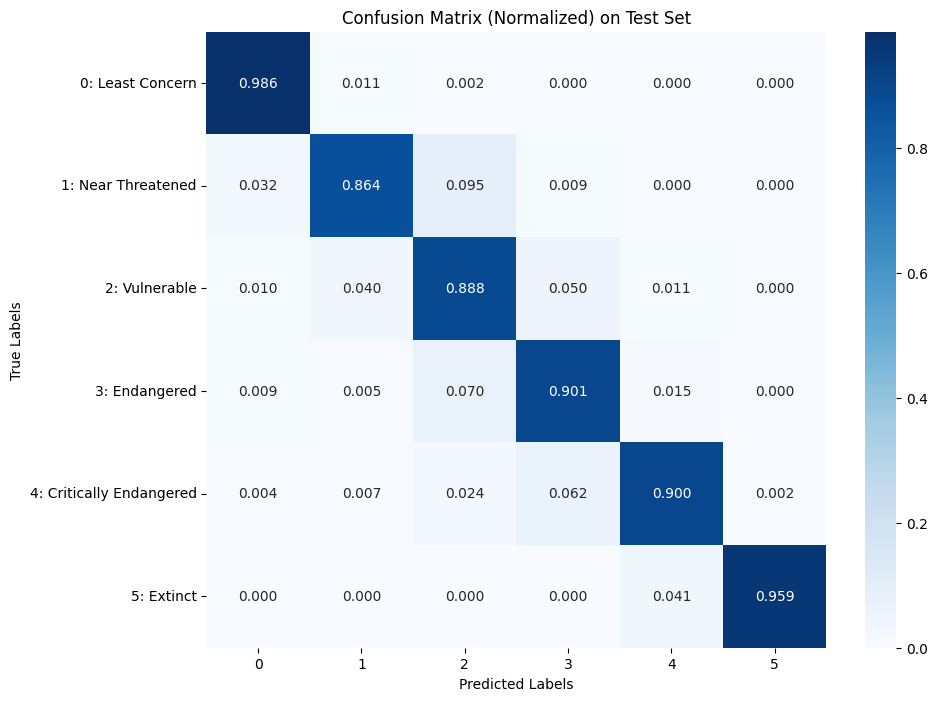

In [25]:
plot_confusion_matrix(test_true_labels, test_preds, is_normalized=True, title_str=' on Test Set')

Predict the data deficient (unlabeled) data

In [11]:
deficient_dataset = RedlistDataset(df_deficient, tokenizer)
deficient_loader = DataLoader(deficient_dataset, batch_size=16)

In [16]:
# Create a dataset and dataloader for df_deficient


# Make predictions
model.eval()
deficient_predictions = []

with torch.no_grad():
    for batch in tqdm(deficient_loader, desc="Predicting on df_deficient"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        logits = model(input_ids, attention_mask, structured_input)
        preds = torch.argmax(logits, dim=1)
        deficient_predictions.extend(preds.cpu().numpy())

print("Predictions on df_deficient:", deficient_predictions)

Predicting on df_deficient: 100%|██████████| 512/512 [01:57<00:00,  4.37it/s]

Predictions on df_deficient: [2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 3, 3, 2, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 1, 4, 2, 4, 0, 2, 0, 0, 4, 2, 3, 2, 0, 4, 0, 0, 0, 0, 5, 5, 3, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 4, 3, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 4, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 0, 0, 1, 3, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 2, 1, 0, 4, 2, 2, 0, 0, 0, 0, 4, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 3, 0, 0, 1, 0, 0, 4

In [12]:
from collections import Counter

# Count the occurrences of each unique value in deficient_predictions
unique_counts = Counter(deficient_predictions)

# Print the unique value counts
print("Unique value counts of df_deficient predictions:")
for category, count in sorted(unique_counts.items()):
    print(f"Category {category}: {count}, {count/len(deficient_predictions):.4f}")

Unique value counts of df_deficient predictions:
Category 0: 6043, 0.7387
Category 1: 565, 0.0691
Category 2: 994, 0.1215
Category 3: 243, 0.0297
Category 4: 318, 0.0389
Category 5: 18, 0.0022


In [13]:
import matplotlib.pyplot as plt

# Unique categories across both charts
all_categories = list(set(label_to_category.values()))

# Generate a fixed color map using a colormap like tab10
color_map = {category: plt.cm.tab10(i % 10) for i, category in enumerate(sorted(all_categories, reverse=True))}


In [29]:
unique_counts

Counter({2: 994, 0: 6043, 1: 565, 4: 318, 3: 243, 5: 18})

In [ ]:
len(df_deficient)+len(df)

8181

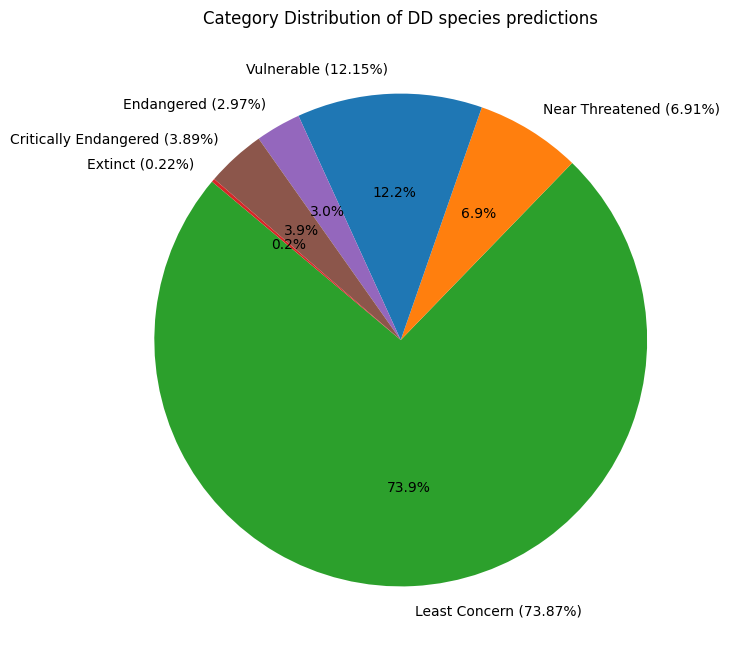

In [15]:
# Sort the keys
sorted_keys = sorted(unique_counts.keys())

# Extract sorted categories and counts
categories = [label_to_category[key] for key in sorted_keys]
counts = [unique_counts[key] for key in sorted_keys]
fractions = [f"{count / sum(counts):.2%}" for count in counts]

# Combine labels
labels = [f"{category} ({fraction})" for category, fraction in zip(categories, fractions)]
colors = [color_map[category] for category in categories]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Category Distribution of DD species predictions")
plt.show()


In [18]:
# Combine df_train and df_test
df_combined = pd.concat([df_train, df_test])
df_combined['redlistCategory'] = df_combined['redlistCategory'] - 1
combined_counts = df_combined['redlistCategory'].value_counts().sort_index()

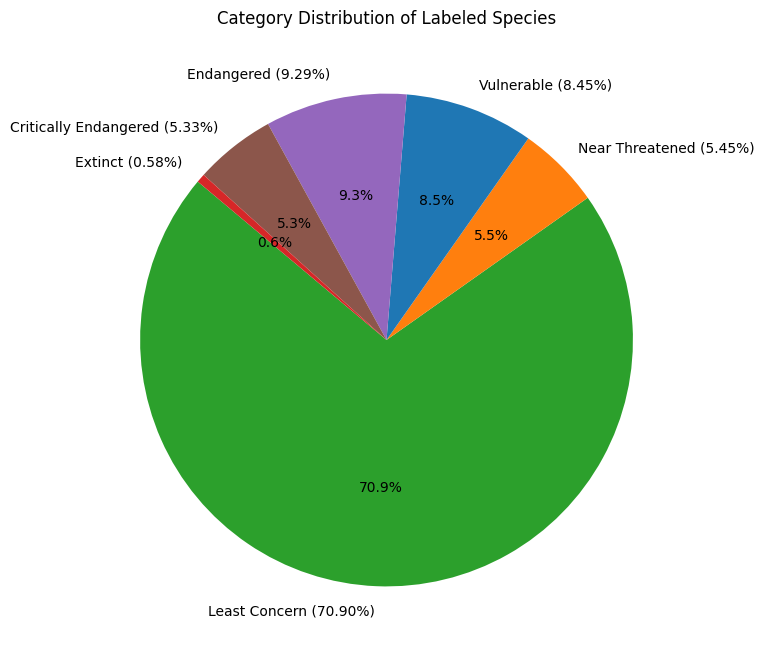

In [20]:
# Sort the keys (index of combined_counts)
sorted_labels = sorted(combined_counts.index)

# Extract sorted categories and counts
categories = [label_to_category[label] for label in sorted_labels]
counts = [combined_counts[label] for label in sorted_labels]
fractions = [f"{count / sum(counts):.2%}" for count in counts]

# Combine labels
labels = [f"{category} ({fraction})" for category, fraction in zip(categories, fractions)]
colors = [color_map[category] for category in categories]

# Plot
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Category Distribution of Labeled Species")
plt.show()


In [ ]:
# from collections import Counter

# # Count the occurrences of each unique value in deficient_predictions
# unique_counts = Counter(deficient_predictions)

# # Print the unique value counts
# print("Unique value counts of df_deficient predictions:")
# for category, count in sorted(unique_counts.items()):
#     print(f"Category {category}: {count}, {count/len(deficient_predictions):.4f}")

In [19]:
import torch.nn.functional as F

deficient_predictions = []
deficient_confidences = []
deficient_all_probs = []

model.eval()
with torch.no_grad():
    for batch in tqdm(deficient_loader, desc="Predicting on df_deficient"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        logits = model(input_ids, attention_mask, structured_input)
        probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

        top_probs, top_preds = torch.max(probs, dim=1)

        deficient_predictions.extend(top_preds.cpu().numpy())
        deficient_confidences.extend(top_probs.cpu().numpy())
        deficient_all_probs.extend(probs.cpu().numpy()) 

Predicting on df_deficient: 100%|██████████| 512/512 [01:56<00:00,  4.38it/s]


In [26]:
with open('results.pkl', 'wb') as f:
    pkl.dump(test_res, f)
    pkl.dump(test_preds, f)
    pkl.dump(test_true_labels, f)
    pkl.dump(deficient_predictions, f)
    pkl.dump(deficient_confidences, f)
    pkl.dump(deficient_all_probs, f)

In [16]:
test_res

{'loss': 0.15133409391734143,
 'accuracy': 0.9503771805752004,
 'precision': 0.8918673902665004,
 'recall': 0.8922087168261914,
 'f1': 0.8917366953953826}

In [20]:
import pandas as pd

# Create a DataFrame with the required columns
df_predictions = pd.DataFrame({
    'assessmentId': df_deficient['assessmentId'],
    'scientificName': df_deficient['scientificName'],
    'modelPrediction': [label_to_category[label] for label in deficient_predictions],
    'confidence': deficient_confidences,
})

# Save the DataFrame to a CSV file
df_predictions.to_csv('data_deficient_predictions.csv', index=False)

print("CSV file 'data_deficient_predictions.csv' has been created.")

CSV file 'data_deficient_predictions.csv' has been created.


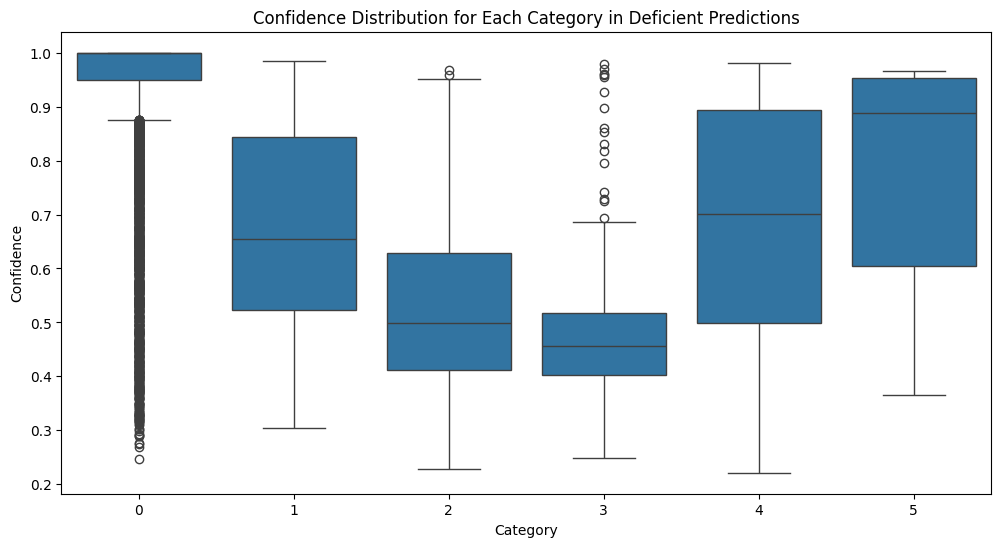

In [21]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Create a DataFrame for visualization
data = pd.DataFrame({
    'Category': deficient_predictions,
    'Confidence': deficient_confidences
})

# Plot the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='Confidence', data=data)
plt.title('Confidence Distribution for Each Category in Deficient Predictions')
plt.xlabel('Category')
plt.ylabel('Confidence')
plt.show()

In [27]:
from collections import Counter

# Count the occurrences of each category in the predictions
category_counts = Counter(deficient_predictions)

# Calculate the normalized counts
total_predictions = len(deficient_predictions)
normalized_counts = {category: count / total_predictions for category, count in category_counts.items()}

# Print the results
print("Category Counts:", category_counts)
print("Normalized Counts:", normalized_counts)

Category Counts: Counter({0: 6043, 2: 994, 1: 565, 4: 318, 3: 243, 5: 18})
Normalized Counts: {2: 0.12150103899278816, 0: 0.7386627551644054, 1: 0.06906246180173573, 4: 0.03887055372203887, 3: 0.0297029702970297, 5: 0.0022002200220022}


In [28]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

import matplotlib.pyplot as plt

# Extract embeddings for data deficient species
model.eval()
embeddings = []

with torch.no_grad():
    for batch in tqdm(deficient_loader, desc="Extracting embeddings"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        # Get embeddings from the model
        bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_embed = model.text_proj(bert_output)
        struct_embed = model.struct_proj(structured_input)
        combined_embed = torch.cat((text_embed, struct_embed), dim=1)
        embeddings.append(combined_embed.cpu().numpy())

# Concatenate all embeddings
embeddings = np.concatenate(embeddings, axis=0)

Extracting embeddings:   0%|          | 0/512 [00:00<?, ?it/s]

Extracting embeddings: 100%|██████████| 512/512 [01:56<00:00,  4.39it/s]


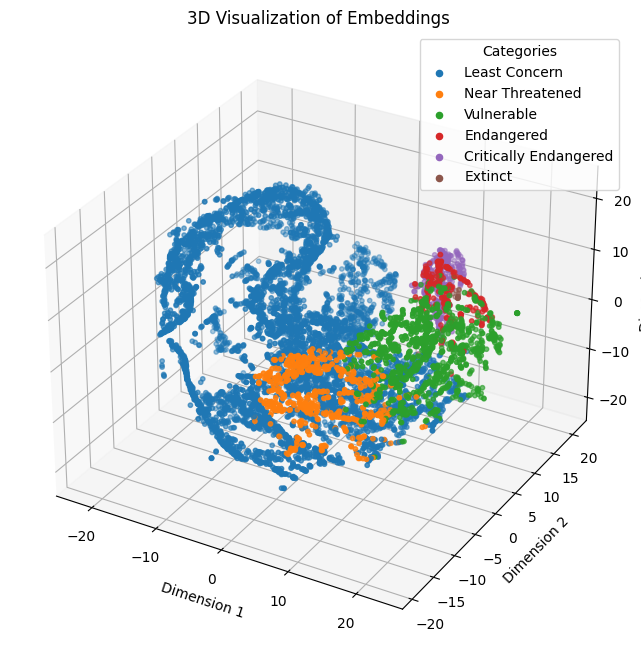

In [29]:
# Reduce dimensionality to 3D using t-SNE
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Plot the 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Map predictions to colors
colors = [plt.cm.tab10(label) for label in deficient_predictions]

# Scatter plot
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors, s=10)

# Add legend
unique_labels = sorted(set(deficient_predictions))
legend_labels = [label_to_category[label] for label in unique_labels]
legend_colors = [plt.cm.tab10(label) for label in unique_labels]
for label, color in zip(legend_labels, legend_colors):
    ax.scatter([], [], c=[color], label=label)
ax.legend(title="Categories")

# Set titles and labels
ax.set_title("3D Visualization of Embeddings")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

Check feature importance

In [30]:
with torch.no_grad():
    weight_matrix = model.struct_proj.weight.cpu().numpy()  # shape: [hidden_dim, structured_input_dim]

# Compute average absolute weight per input dimension
importance_per_dim = np.mean(np.abs(weight_matrix), axis=0)  # shape: [structured_input_dim]

In [31]:
importance_per_dim

array([0.13458872, 0.13346845, 0.13609606, 0.13496341, 0.12728232,
       0.13221668, 0.13198341, 0.13180201, 0.12902154, 0.1287846 ,
       0.12588516, 0.13022481, 0.13149896, 0.12153661, 0.12422337],
      dtype=float32)

In [32]:
dim_pop_trend = 0  
dim_possibly_extinct = 0
dim_possibly_extinct_in_wild = 0
dim_realm = len(df_train.iloc[0]['realm_vector'])  # e.g., 9
dim_systems = len(df_train.iloc[0]['systems_vector'])  # e.g., 3

# Compute start/end indices for each feature group
group_dims = {
    # 'populationTrend': (0, dim_pop_trend),
    # 'possiblyExtinct': (dim_pop_trend, dim_pop_trend + dim_possibly_extinct),
    # 'possiblyExtinctInTheWild': (
    #     dim_pop_trend + dim_possibly_extinct,
    #     dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild
    # ),
    'realm_vector': (
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild,
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild + dim_realm
    ),
    'systems_vector': (
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild + dim_realm,
        dim_pop_trend + dim_possibly_extinct + dim_possibly_extinct_in_wild + dim_realm + dim_systems
    )
}


In [33]:
group_dims

{'realm_vector': (0, 9), 'systems_vector': (9, 12)}

In [34]:
group_importance = {}

for group, (start, end) in group_dims.items():
    group_importance[group] = importance_per_dim[start:end].mean()


In [35]:
group_importance

{'realm_vector': 0.13238029, 'systems_vector': 0.12829818}

In [36]:
text_norms = []
struct_norms = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        structured_input = batch['structured_input'].to(device)

        # Forward up to projection layer
        bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_embed = model.text_proj(bert_output)
        struct_embed = model.struct_proj(structured_input)

        text_norms.append(text_embed.norm(p=2, dim=1).cpu().numpy())
        struct_norms.append(struct_embed.norm(p=2, dim=1).cpu().numpy())

# Average over all batches
import numpy as np
mean_text = np.mean(np.concatenate(text_norms))
mean_struct = np.mean(np.concatenate(struct_norms))

print(f"Mean L2 norm of text_embed:    {mean_text:.4f}")
print(f"Mean L2 norm of struct_embed:  {mean_struct:.4f}")
print(f"Relative contribution (text / (text + struct)): {mean_text / (mean_text + mean_struct):.3f}")


Mean L2 norm of text_embed:    37.5027
Mean L2 norm of struct_embed:  5.6723
Relative contribution (text / (text + struct)): 0.869
